In [4]:
import os
from osgeo import gdal
import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, ndimage

from pyproj import Proj, Geod

%load_ext autoreload
%autoreload 2

In [5]:
def rotate_stripe_remove(data, cutoff, fs, order=4, angle=0, nodata=np.nan):
    """
    Rotate data do stripes are horizontal, average signal along rows, 
    low pass filter the average, remove low pass from the average, 
    remove the remaining average from the rows,
    restore the image to its original dimensions.

    Parameters:
    - data: 2D numpy array (input image)
    - cutoff: float (cutoff frequency for low-pass filter)
    - fs: float (sampling frequency for filter)
    - order: int (order of the Butterworth filter)
    - angle: float (rotation angle in degrees)
    - nodata: float or np.nan (value to treat as NoData)

    Returns:
    - unrotated_data: 2D numpy array (filtered image with original dimensions)
    - filt_data: 2D numpy array (intermediate rotated and filtered image)
    """

    # Step 1: Rotate Image
    rotated_data = ndimage.rotate(data, angle=angle, reshape=True, order=1, mode="constant", cval=nodata)
    
    # Replace NoData values with NaN
    rotated_data[rotated_data == nodata] = np.nan
    
    # Step 2: Compute Row-Wise Average
    y = np.nanmean(rotated_data,axis=1)  # Use nanmean to ignore NoData values
    y[np.isnan(y)] = 0

    # Step 3: Apply Low-Pass Filter
    b, a = signal.butter(order, cutoff, fs=fs, btype='low', analog=False)
    yfilt = signal.filtfilt(b, a, y)
    yfilt[y==0] = np.nan

    # Step 4: Remove Low-Frequency Stripes
    filt_data = rotated_data - (y - yfilt)[:, None]

    # Step 5: Rotate Back
    unrotated_data = ndimage.rotate(filt_data, angle=-angle, reshape=True, order=1, mode="constant", cval=nodata)

    # Step 6: Crop to Original Size
    center_x, center_y = np.array(unrotated_data.shape) // 2
    orig_x, orig_y = np.array(data.shape) // 2
    cropped_data = unrotated_data[
        center_x - orig_x : center_x + orig_x,
        center_y - orig_y : center_y + orig_y
    ]

    # Step 7: Ensure Final Shape Matches Original
    if cropped_data.shape != data.shape:
        pad_x = max(0, data.shape[0] - cropped_data.shape[0])
        pad_y = max(0, data.shape[1] - cropped_data.shape[1])
        cropped_data = np.pad(cropped_data, ((0, pad_x), (0, pad_y)), mode='constant', constant_values=nodata)

    cropped_data[cropped_data == np.nan] = nodata

    # Step 8: Visualization (Optional)
    x = np.arange(len(y))
    plt.plot(x, y, label='Original')
    plt.plot(x, yfilt, label='Low-pass')
    plt.plot(x, y - yfilt, label='Remove')
    plt.legend()
    plt.show()

    return cropped_data# Return both for analysis

In [ ]:
scp to hovenweep

# Sentinel 

Copernicus
client id: sh-c909b61b-21ad-4bda-9ee9-9c0c228a3270
client secret: w2XPWZxLUhkrMQGgETnr6wAHAKYjm3vI

USED QGIS Plugin

In [ ]:
STOP
%%bash
for file in /Volumes/Myanmar/Imagery/Sentinel/POST/*.jp2; do
    gdalwarp -t_srs EPSG:32647 -r near -tr 10 10 -srcnodata 0 -dstnodata 0 -overwrite -of GTiff -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 "$file" "${file%.tif}.tif"
done

Creating output file that is 11382P x 11382L.
Processing /Volumes/Myanmar/Imagery/Sentinel/POST/QGIS_Dowload\S2B_MSIL2A_20250330T040549_N0511_R047_T46QGH_20250330T061335\T46QGH_20250330T040549_B04_10m.jp2 [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 11398P x 11398L.
Processing /Volumes/Myanmar/Imagery/Sentinel/POST/QGIS_Dowload\S2B_MSIL2A_20250330T040549_N0511_R047_T46QGJ_20250330T061335\T46QGJ_20250330T040549_B04_10m.jp2 [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 11414P x 11414L.
Processing /Volumes/Myanmar/Imagery/Sentinel/POST/QGIS_Dowload\S2B_MSIL2A_20250330T040549_N0511_R047_T46QGK_20250330T061335\T46QGK_20250330T040549_B04_10m.jp2 [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 11331P x 11331L.
Processing /Volumes/Myanmar/Imagery/Sentinel/POST/QGIS_Dowload\S2B_MSIL2A_20250330T040549_N0511_R047_T46QHF_20250330T061335\T46QHF_2

In [ ]:
STOP
%%bash
gdal_merge.py -n 0 -a_nodata 0 -ot Float32 -of GTiff -ps 10 10 -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 -co BIGTIFF=YES \
    -o /Volumes/Myanmar/Imagery/Sentinel/S2_20250330and0401_B04_10m_merged.tif \
    /Volumes/Myanmar/Imagery/Sentinel/POST/*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
STOP
%%bash
gdal_merge.py -n 0 -a_nodata 0 -ot Float32 -of GTiff -ps 10 10 -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 -co BIGTIFF=YES \
    -o /Volumes/Myanmar/Imagery/Sentinel/S2_20250325and27_B04_10m_merged.tif \
    /Volumes/Myanmar/Imagery/Sentinel/PRE2/*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


/var/folders/zn/w54gt7k11csfs1n4z8r3xccsyqhmjz/T/ipykernel_58919/3627750453.py:28: RuntimeWarning: Mean of empty slice
  y = np.nanmean(rotated_data,axis=1)  # Use nanmean to ignore NoData values


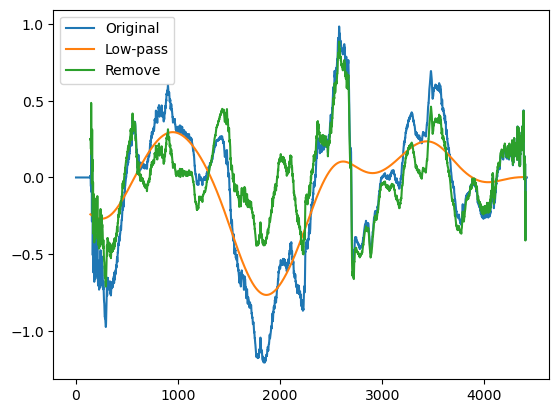

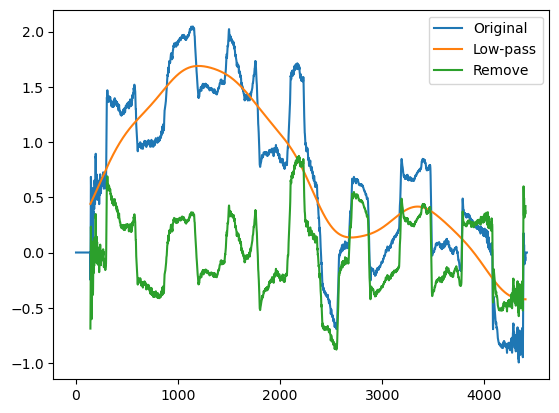

In [ ]:
# Split result
im = gdal.Open('/Volumes/Myanmar/Imagery/Sentinel/MergedResults/S2_20250325and27_B04_10m_merged_VS_S2_20250330and0401_B04_10m_merged_frequency_wz_64_step_8.tif')
imdata = im.GetRasterBand(1).ReadAsArray() #EW
imdata[np.absolute(imdata)>10] = 0
imdata[np.isnan(imdata)] = 0
destriped = rotate_stripe_remove(imdata, 0.0008, fs=1, order=2,angle=-76.4,nodata=0)
#tt.save_geotiff(destriped,'/Volumes/Myanmar/Imagery/Sentinel/MergedResults/S2_20250325and27_B04_10m_merged_VS_S2_20250330and0401_B04_10m_merged_frequency_wz_64_step_8-desriped76.5_EW.tif',
#                im.GetGeoTransform(),im.GetProjection())
imdata = im.GetRasterBand(2).ReadAsArray() #NS
imdata[np.absolute(imdata)>10] = 0
imdata[np.isnan(imdata)] = 0
destriped = rotate_stripe_remove(imdata, 0.0008, fs=1, order=2,angle=-76.4,nodata=0)
#tt.save_geotiff(destriped,'/Volumes/Myanmar/Imagery/Sentinel/MergedResults/S2_20250325and27_B04_10m_merged_VS_S2_20250330and0401_B04_10m_merged_frequency_wz_64_step_8-desriped76.5_NS.tif',
#                im.GetGeoTransform(),im.GetProjection())

# Landsat Pre Mosaic

In [ ]:
STOP
!gdalwarp -overwrite -of GTiff -tr 15 15 -cutline /Volumes/Myanmar/GIS/LandsatAOI.shp -crop_to_cutline /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250316_02_RT_B8.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250316_02_RT_B8-mergecropped.TIF 
!gdalwarp -overwrite -of GTiff -tr 15 15 -cutline /Volumes/Myanmar/GIS/LandsatAOI.shp -crop_to_cutline /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250401_02_RT_B8.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250401_02_RT_B8-mergecropped.TIF

Creating output file that is 20125P x 36613L.
Using internal nodata values (e.g. 0) for image /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250316_02_RT_B8.TIF.
Copying nodata values from source /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250316_02_RT_B8.TIF to destination /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250316_02_RT_B8-mergecropped.TIF.
Processing /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250316_02_RT_B8.TIF [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 20125P x 36613L.
Using internal nodata values (e.g. 0) for image /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250401_02_RT_B8.TIF.
Copying nodata values from source /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250401_02_RT_B8.TIF to destination /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250401_02_RT_B8-mergecropped.TIF.
Processing /Volumes/Myanmar/Imagery/L

In [ ]:
python3 ../Geospatial-COSICorr3D/scripts/cosicorr.py correlate LC08_L1TP_133_44through47_20250316_02_RT_B8-mergecropped.TIF LC08_L1TP_133_44through47_20250401_02_RT_B8-mergecropped.TIF --output ./ 


In [ ]:
# Merged in QGIS
/Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250401_02_RT_B8.TIF 
/Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250316_02_RT_B8.TIF

In [ ]:
%%bash
gdalwarp -t_srs EPSG:32647 -r near -tr 15 15 -srcnodata 0 -dstnodata 0 -overwrite -of GTiff -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133046_20250401_20250401_02_RT_B8.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133046_20250401_20250401_02_RT_B8.epsg32647.TIF 
gdalwarp -t_srs EPSG:32647 -r near -tr 15 15 -srcnodata 0 -dstnodata 0 -overwrite -of GTiff -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133047_20250401_20250401_02_RT_B8.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133047_20250401_20250401_02_RT_B8.epsg32647.TIF 
gdalwarp -t_srs EPSG:32647 -r near -tr 15 15 -srcnodata 0 -dstnodata 0 -overwrite -of GTiff -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133045_20250401_20250401_02_RT_B8.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133045_20250401_20250401_02_RT_B8.epsg32647.TIF 
gdalwarp -t_srs EPSG:32647 -r near -tr 15 15 -srcnodata 0 -dstnodata 0 -overwrite -of GTiff -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133044_20250401_20250401_02_RT_B8.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133044_20250401_20250401_02_RT_B8.epsg32647.TIF


Creating output file that is 15611P x 15920L.
Processing /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133046_20250401_20250401_02_RT_B8.TIF [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 15584P x 15912L.
Processing /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133047_20250401_20250401_02_RT_B8.TIF [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 15401P x 15701L.
Processing /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133045_20250401_20250401_02_RT_B8.TIF [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 15401P x 15701L.
Processing /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133044_20250401_20250401_02_RT_B8.TIF [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [11]:
%%bash
gdalwarp  -t_srs EPSG:32647 -r near -tr 15 15 -srcnodata 0 -dstnodata 0 -overwrite -of GTiff -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133044_20250316_20250327_02_T1_B8.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133044_20250316_20250327_02_T1_B8.epsg32647.TIF 
gdalwarp  -t_srs EPSG:32647 -r near -tr 15 15 -srcnodata 0 -dstnodata 0 -overwrite -of GTiff -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133045_20250316_20250327_02_T1_B8.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133045_20250316_20250327_02_T1_B8.epsg32647.TIF 
gdalwarp  -t_srs EPSG:32647 -r near -tr 15 15 -srcnodata 0 -dstnodata 0 -overwrite -of GTiff -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133046_20250316_20250327_02_T1_B8.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133046_20250316_20250327_02_T1_B8.epsg32647.TIF 
gdalwarp  -t_srs EPSG:32647 -r near -tr 15 15 -srcnodata 0 -dstnodata 0 -overwrite -of GTiff -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133047_20250316_20250327_02_T1_B8.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133047_20250316_20250327_02_T1_B8.epsg32647.TIF 

Creating output file that is 15421P x 15701L.
Processing /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133044_20250316_20250327_02_T1_B8.TIF [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 15401P x 15701L.
Processing /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133045_20250316_20250327_02_T1_B8.TIF [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 15611P x 15920L.
Processing /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133046_20250316_20250327_02_T1_B8.TIF [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 15583P x 15912L.
Processing /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133047_20250316_20250327_02_T1_B8.TIF [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [15]:
!gdal_merge.py -n 0 -a_nodata 0 -o /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250401_02_RT_B8.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133044_20250401_20250401_02_RT_B8.epsg32647.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133045_20250401_20250401_02_RT_B8.epsg32647.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133047_20250401_20250401_02_RT_B8.epsg32647.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133046_20250401_20250401_02_RT_B8.epsg32647.TIF

0...10...20...30...40...50...60...70...80...90...100 - done.


In [12]:
!gdal_merge.py -n 0 -a_nodata 0 -o /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133_44through47_20250316_02_RT_B8.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133045_20250316_20250327_02_T1_B8.epsg32647.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133044_20250316_20250327_02_T1_B8.epsg32647.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133046_20250316_20250327_02_T1_B8.epsg32647.TIF /Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133047_20250316_20250327_02_T1_B8.epsg32647.TIF

0...10...20...30...40...50...60...70...80...90...100 - done.


# Landsat - Tiles




In [ ]:
python3 ../../Geospatial-COSICorr3D/scripts/cosicorr.py correlate LC08_L1TP_133047_20250316_20250327_02_T1_B8.TIF LC08_L1TP_133047_20250401_20250401_02_RT_B8.TIF --output ./ 
python3 ../../Geospatial-COSICorr3D/scripts/cosicorr.py correlate LC08_L1TP_133045_20250316_20250327_02_T1_B8.TIF LC08_L1TP_133045_20250401_20250401_02_RT_B8.TIF --output ./
python3 ../../Geospatial-COSICorr3D/scripts/cosicorr.py correlate LC08_L1TP_133046_20250316_20250327_02_T1_B8.TIF LC08_L1TP_133046_20250401_20250401_02_RT_B8.TIF --output ./
python3 ../../Geospatial-COSICorr3D/scripts/cosicorr.py correlate LC08_L1TP_133044_20250316_20250327_02_T1_B8.TIF LC08_L1TP_133044_20250401_20250401_02_RT_B8.TIF --output ./

'/Volumes/Myanmar/Imagery/Landsat/LC08_L1TP_133045_46_47_20250316_20250316_02_RT_B8_merge.crop_VS_LC08_L1TP_133045_46_47_20250401_20250401_02_RT_B8_merge.crop'

In [ ]:
flist = [
'/Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132048_20250317_20250317_02_T1_B8.TIF',
'/Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132046_20250317_20250317_02_T1_B8.TIF',
'/Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132047_20250317_20250317_02_T1_B8.TIF',
'/Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132048_20250402_20250402_02_T1_B8.TIF',
'/Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132046_20250402_20250402_02_T1_B8.TIF',
'/Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132047_20250402_20250402_02_T1_B8.TIF'
]
rewrite = False
for file1, file2 in zip(flist[:3],flist[3:]):
    im1 = gdal.Open(file1)
    im2 = gdal.Open(file2)
    print(im1.GetRasterBand(1).ReadAsArray().shape,im2.GetRasterBand(1).ReadAsArray().shape)
    bounds = tt.getOverlap(im1,im2)

    for im, file in zip([im1,im2],[file1,file2]):
        if rewrite == True:
            with gdal.Warp(
            f'{file[:-4]}-cropped.tif',
            im,
            srcSRS='EPSG:32647',
            dstSRS='EPSG:32647',
            outputBounds=bounds,
            srcNodata=0,
            dstNodata=0,
            format='GTiff',
            resampleAlg='near',
            xRes=15,
            yRes=15  # Use a positive value for yRes
            ) as im:
                im.FlushCache()

(15621, 15321) (15621, 15321)
(ulx, uly, lrx, lry)
	1 bounding box: [147892.5, 2035807.5, 377707.5, 1801492.5]
	2 bounding box: [149392.5, 2035807.5, 379207.5, 1801492.5]
minx, miny, maxx, maxy:
149392.5 1801492.5 377707.5 2035807.5
(15601, 15301) (15601, 15321)
(ulx, uly, lrx, lry)
	1 bounding box: [221092.5, 2354407.5, 450607.5, 2120392.5]
	2 bounding box: [222292.5, 2354407.5, 452107.5, 2120392.5]
minx, miny, maxx, maxy:
222292.5 2120392.5 450607.5 2354407.5
(15621, 15321) (15621, 15301)
(ulx, uly, lrx, lry)
	1 bounding box: [184492.5, 2195107.5, 414307.5, 1960792.5]
	2 bounding box: [185992.5, 2195107.5, 415507.5, 1960792.5]
minx, miny, maxx, maxy:
185992.5 1960792.5 414307.5 2195107.5


In [ ]:
/Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132047_20250317_20250317_02_T1_B8-cropped.tif /Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132047_20250402_20250402_02_T1_B8-cropped.tif /Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132048_20250317_20250317_02_T1_B8-cropped.tif /Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132048_20250402_20250402_02_T1_B8-cropped.tif /Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132046_20250317_20250317_02_T1_B8-cropped.tif /Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132046_20250402_20250402_02_T1_B8-cropped.tif

In [ ]:
WORK IN PROGRESS - Like abouve, but account for bounds and nodata
im1file = flist[2]
im2file = flist[5]
resolution=15

with rasterio.open(im1file) as im1, \
        rasterio.open(im2file) as im2:
    # Get the bounding boxes of both images
    im1_bounds = im1.bounds
    im2_bounds = im2.bounds
    # Find the intersection of the two bounding boxes
    min_bound = (
        max(im1_bounds[0], im2_bounds[0]),  # xmin
        max(im1_bounds[1], im2_bounds[1]),  # ymin
        min(im1_bounds[2], im2_bounds[2]),  # xmax
        min(im1_bounds[3], im2_bounds[3])   # ymax
    )
    width_m = min(im1.transform[2], im2.transform[2])
    height_m = min(im1.transform[5], im2.transform[5])
    #new_transform = (im1.transform,resolution,0,-1*resolution,width_m, height_m)

    new_transform = Affine.translation(width_m, height_m)  # Remove any previous translations
    new_transform = new_transform * Affine.scale(resolution, -resolution)  # Apply new resolution

    geom = box(*min_bound)
    
with rasterio.open(flist[0]) as im1, \
        rasterio.open(flist[3]) as im2:
    # mask for where both rasters are nodata
    mask1 = rasterio.mask.mask(im1,shapes=[geom],crop=True,nodata=im1.nodata)
    mask2 = rasterio.mask.mask(im2,shapes=[geom],crop=True,nodata=im2.nodata)

    mask1[0][mask2[0] == im2.nodata] = im1.nodata
    mask2[0][mask1[0] == im1.nodata] = im2.nodata

   # save the result
   # (don't forget to set the appropriate metadata)
    # save the result
    # (don't forget to set the appropriate metadata)
    with rasterio.open(
        f'{im1file[:-4]}-cropped.tif', 'w', driver='GTiff',
        height=mask1[0][0].shape[0], width=mask1[0][0].shape[1],
        count=1, dtype=im1.read(1).dtype, crs=im1.crs,
        transform=new_transform,compress='LZW', 
        nodata=im1.nodata
        ) as dst:
            dst.write(mask1[0][0], 1)

    with rasterio.open(
        f'{im2file[:-4]}-cropped.tif', 'w', driver='GTiff',
        height=mask1[0][0].shape[0], width=mask1[0][0].shape[1],
        count=1, dtype=im2.read(1).dtype, crs=im2.crs,
        transform=new_transform,compress='LZW', 
        nodata=im2.nodata
        ) as dst:
            dst.write(mask2[0][0], 1)



IndexError: boolean index did not match indexed array along axis 1; size of axis is 12781 but size of corresponding boolean axis is 12881

/var/folders/zn/w54gt7k11csfs1n4z8r3xccsyqhmjz/T/ipykernel_6028/3627750453.py:28: RuntimeWarning: Mean of empty slice
  y = np.nanmean(rotated_data,axis=1)  # Use nanmean to ignore NoData values


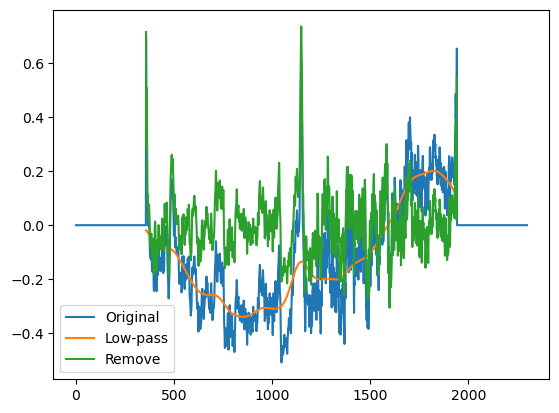

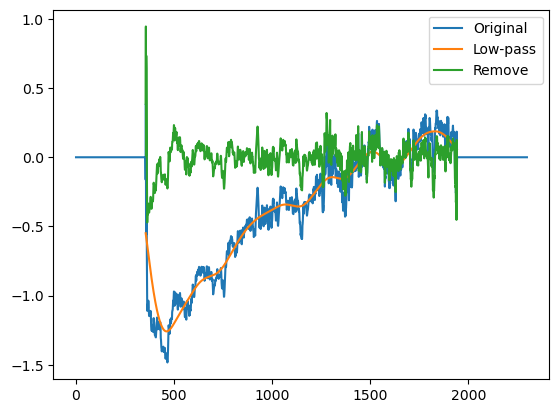

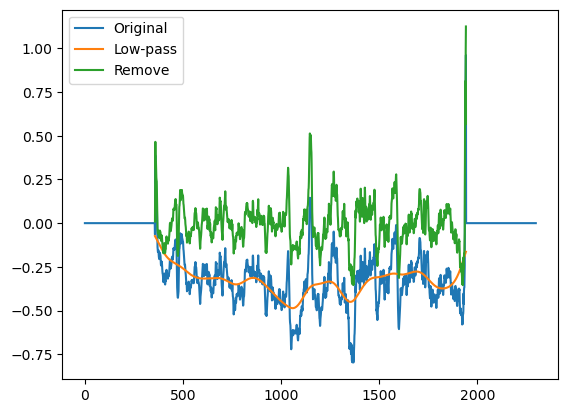

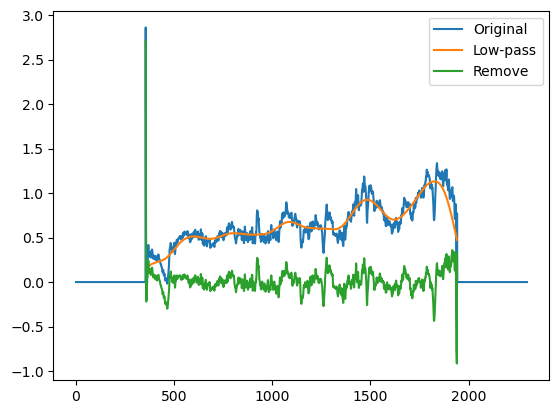

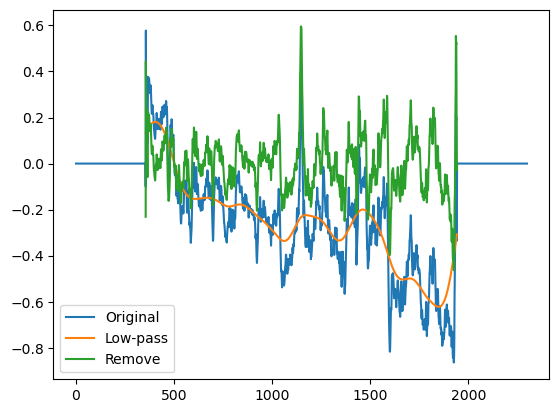

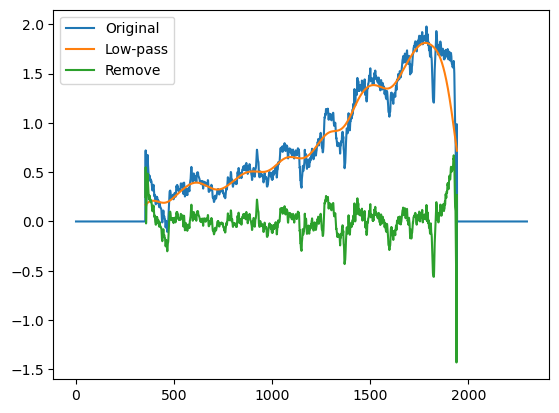

In [121]:
# Split result
#flist = ['/Volumes/Myanmar/Imagery/Landsat/LC08Tiles/cosicorr/LC08_L1TP_133046_20250316_20250327_02_T1_B8_VS_LC08_L1TP_133046_20250401_20250401_02_RT_B8_frequency_wz_64_step_8.tif', 
#         '/Volumes/Myanmar/Imagery/Landsat/LC08Tiles/cosicorr/LC08_L1TP_133044_20250316_20250327_02_T1_B8_VS_LC08_L1TP_133044_20250401_20250401_02_RT_B8_frequency_wz_64_step_8.tif', 
#         '/Volumes/Myanmar/Imagery/Landsat/LC08Tiles/cosicorr/LC08_L1TP_133045_20250316_20250327_02_T1_B8_VS_LC08_L1TP_133045_20250401_20250401_02_RT_B8_frequency_wz_64_step_8.tif', 
#         '/Volumes/Myanmar/Imagery/Landsat/LC08Tiles/cosicorr/LC08_L1TP_133047_20250316_20250327_02_T1_B8_VS_LC08_L1TP_133047_20250401_20250401_02_RT_B8_frequency_wz_64_step_8.tif']
flist = ['/Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132048_20250317_20250317_02_T1_B8-cropped_VS_LC09_L1TP_132048_20250402_20250402_02_T1_B8-cropped_frequency_wz_64_step_8.tif',
    '/Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132046_20250317_20250317_02_T1_B8-cropped_VS_LC09_L1TP_132046_20250402_20250402_02_T1_B8-cropped_frequency_wz_64_step_8.tif',
    '/Volumes/Myanmar/Imagery/Landsat/LC09Tiles/LC09_L1TP_132047_20250317_20250317_02_T1_B8-cropped_VS_LC09_L1TP_132047_20250402_20250402_02_T1_B8-cropped_frequency_wz_64_step_8.tif']

for file in flist:
    im = gdal.Open(file)
    angle = -76.8
    imdata = im.GetRasterBand(1).ReadAsArray() #EW
    imdata[np.absolute(imdata)>10] = 0
    imdata[np.isnan(imdata)] = 0
    mask = ((imdata == 0)&(imdata == -9999))
    destriped = rotate_stripe_remove(imdata, 0.004, fs=1, order=2,angle=angle,nodata=0)
    destriped[mask] = -9999
    tt.save_geotiff(destriped,f'{file[:-27]}-destriped{angle}_EW.tif',
                    im.GetGeoTransform(),im.GetProjection(),nodata=-9999)
    imdata = im.GetRasterBand(2).ReadAsArray() #NS
    imdata[np.absolute(imdata)>10] = 0
    imdata[np.isnan(imdata)] = 0
    destriped = rotate_stripe_remove(imdata, 0.004, fs=1, order=2,angle=angle,nodata=0)
    destriped[mask] = -9999
    tt.save_geotiff(destriped,f'{file[:-27]}-destriped{angle}_NS.tif',
                   im.GetGeoTransform(),im.GetProjection(),nodata=-9999)

# Sentinel - Me

In [ ]:
!gdalinfo /Volumes/Myanmar 1/Imagery/Sentinel/PRE/QGIS_Dowload\S2B_MSIL2A_20250327T035539_N0511_R004_T46QHF_20250327T073409\T46QHF_20250327T035539_B04_10m.jp2

ERROR 1: Maximum number of positional arguments exceeded, failed to parse '1/Imagery/Sentinel/PRE/QGIS_DowloadS2B_MSIL2A_20250327T035539_N0511_R004_T46QHF_20250327T073409T46QHF_20250327T035539_B04_10m.jp2'
Usage: gdalinfo [--help] [--long-usage] [--help-general]
                [-json] [-mm]
                [[-stats]|[-approx_stats]]
                [-hist] [-nogcp] [-nomd] [-norat] [-noct] [-nofl] [-checksum] [-listmdd] [-proj4]
                [-wkt_format <WKT1|WKT2|WKT2_2015|WKT2_2018|WKT2_2019>] [-sd <n>] [-oo <NAME>=<VALUE>]...
                [-if <format>]... [-mdd <domain>|all]
                <dataset_name>


ls: 1/: No such file or directory
/Volumes/Myanmar:
ls: /Volumes/Myanmar: Permission denied


In [ ]:
gdalwarp -t_srs EPSG:32647 -tr 10 10 -srcnodata 0 -dstnodata 0 -overwrite -of GTiff -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 *.jp2 \
    S2B_20250327_20250325_T46T47_B04_merge.tif

gdalwarp -t_srs EPSG:32647 -tr 10 10 -srcnodata 0 -dstnodata 0 -overwrite -of GTiff -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 -co BIGTIFF=YES *.jp2 \
    S2B_20250330_20250401_T46T47_B04_merge.tif

ERROR 4: /Volumes/Myanmar: Permission denied
ERROR 4: Failed to open source file /Volumes/Myanmar



90-77

# Bill's Sentinel

/var/folders/zn/w54gt7k11csfs1n4z8r3xccsyqhmjz/T/ipykernel_58919/2872099138.py:28: RuntimeWarning: Mean of empty slice
  y = np.nanmean(rotated_data,axis=1)  # Use nanmean to ignore NoData values


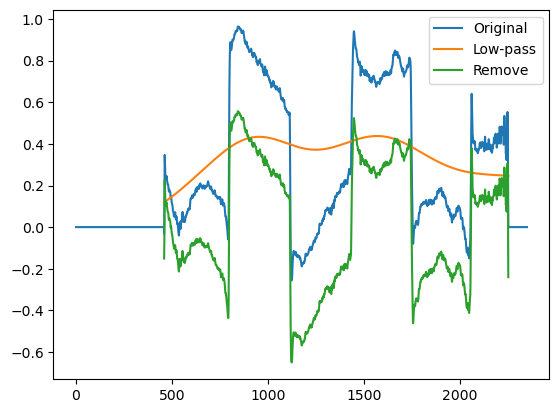

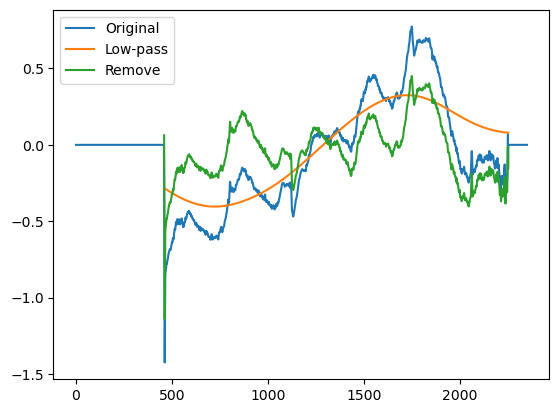

In [ ]:


im = gdal.Open('/Users/chanagan/Downloads/T46Q_20250325_B04_10m_merged_VS_T46Q_20250330_B04_10m_merged_NS.tif')
imdata = im.GetRasterBand(1).ReadAsArray()
imdata[np.absolute(imdata)>10] = 0
imdata[np.isnan(imdata)] = 0
destriped = rotate_stripe_remove(imdata, cutoff=0.0008, fs=1, order=2,angle=-76,nodata=0)
#tt.save_geotiff(destriped,'/Users/chanagan/Downloads/T46Q_20250325_B04_10m_merged_VS_T46Q_20250330_B04_10m_merged_NS-destriped-76.tif',
#                im.GetGeoTransform(),im.GetProjection())

im = gdal.Open('/Users/chanagan/Downloads/T46Q_20250325_B04_10m_merged_VS_T46Q_20250330_B04_10m_merged_EW.tif')
imdata = im.GetRasterBand(1).ReadAsArray()
imdata[np.absolute(imdata)>10] = 0
imdata[np.isnan(imdata)] = 0
destriped = rotate_stripe_remove(imdata, 0.0008, fs=1, order=2,angle=-76,nodata=0)
#tt.save_geotiff(destriped,'/Users/chanagan/Downloads/T46Q_20250325_B04_10m_merged_VS_T46Q_20250330_B04_10m_merged_EW-destriped-76.tif',
#                im.GetGeoTransform(),im.GetProjection())
im = gdal.Open('/Volumes/Myanmar/Imagery/Sentinel/BillsProcessing/s2_20250327_20250401_NS.tif')
imdata = im.GetRasterBand(1).ReadAsArray()
imdata[np.absolute(imdata)>10] = 0
imdata[np.isnan(imdata)] = 0
destriped = rotate_stripe_remove(imdata, cutoff=0.0008, fs=1, order=2,angle=-77,nodata=0)
#tt.save_geotiff(destriped,'/Volumes/Myanmar/Imagery/Sentinel/BillsProcessing/s2_20250327_20250401_NS-destriped-76.tif',
#                im.GetGeoTransform(),im.GetProjection())

im = gdal.Open('/Volumes/Myanmar/Imagery/Sentinel/BillsProcessing/s2_20250327_20250401_EW.tif')
imdata = im.GetRasterBand(1).ReadAsArray()
imdata[np.absolute(imdata)>10] = 0
imdata[np.isnan(imdata)] = 0
destriped = rotate_stripe_remove(imdata, 0.0008, fs=1, order=2,angle=-77,nodata=0)
#tt.save_geotiff(destriped,'/Volumes/Myanmar/Imagery/Sentinel/BillsProcessing/s2_20250327_20250401_EW-destriped-76.tif',
#                im.GetGeoTransform(),im.GetProjection())



In [1]:
1/0.0008

1250.0

In [ ]:
#tt.projectDisp('/Users/chanagan/Downloads/T46Q_20250325_B04_10m_merged_VS_T46Q_20250330_B04_10m_merged_EW-destriped-76.tif',
#                 '/Users/chanagan/Downloads/T46Q_20250325_B04_10m_merged_VS_T46Q_20250330_B04_10m_merged_NS-destriped-76.tif',
#                 -5,
#                 partif='/Users/chanagan/Downloads/T46Q_20250325_B04_10m_merged_VS_T46Q_20250330_B04_10m_merged_destriped_ParallelDisp-5.tif',
#                 perptif='/Users/chanagan/Downloads/T46Q_20250325_B04_10m_merged_VS_T46Q_20250330_B04_10m_merged_destriped_PerpDisp-5.tif')
#

(array([[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ..., nan, nan,  0.],
        [nan, nan, nan, ..., nan, nan,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan,  0.],
        [nan, nan, nan, ..., nan, nan,  0.],
        [nan, nan, nan, ..., nan, nan,  0.]]),
 array([[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ..., nan, nan,  0.],
        [nan, nan, nan, ..., nan, nan,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan,  0.],
        [nan, nan, nan, ..., nan, nan,  0.],
        [nan, nan, nan, ..., nan, nan,  0.]]))

In [52]:
90-12.8

77.2

# Planet

In [16]:
#!ls /Volumes/Myanmar\ 1/Imagery/PlanetOrthos/burma_pre_20250326/*/*AnalyticMS.tif 
!ls /Volumes/Myanmar\ 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/*/*AnalyticMS.tif 
#!ls /Volumes/Myanmar\ 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/*/*AnalyticMS.tif 

/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042720_16_2515_3B_AnalyticMS.tif
/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042722_45_2515_3B_AnalyticMS.tif
/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042724_75_2515_3B_AnalyticMS.tif
/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042727_04_2515_3B_AnalyticMS.tif
/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042729_34_2515_3B_AnalyticMS.tif
/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042756_39_24ee_3B_AnalyticMS.tif
/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042758_60_24ee_3B_AnalyticMS.tif
/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_

In [14]:
flist = [
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042720_16_2515_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042722_45_2515_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042724_75_2515_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042727_04_2515_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042729_34_2515_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042756_39_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042758_60_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042801_03_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042803_24_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042805_45_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042807_66_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042809_87_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042812_09_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042814_30_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042816_51_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042818_72_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042820_93_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042823_15_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042906_03_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042908_20_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042910_38_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042912_56_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042914_74_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042916_91_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042919_09_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042921_27_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042923_45_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043436_59_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043438_96_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043441_32_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043443_69_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043446_05_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043448_42_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043450_78_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043453_15_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043454_32_2546_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043455_51_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043456_46_2546_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043458_59_2546_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043500_73_2546_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043502_86_2546_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043923_41_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043925_78_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043928_14_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043930_51_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043932_87_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043935_24_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043937_60_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043939_97_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043942_33_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044014_23_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044016_36_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044018_50_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044020_63_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044022_76_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044024_90_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044027_03_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044029_16_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044031_30_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044033_43_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044035_56_253d_3B_AnalyticMS.tif'
]

In [17]:
flist = [
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_034621_34_24a7_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_034623_27_24a7_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_034625_21_24a7_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_034627_14_24a7_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_034629_07_24a7_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_042717_47_24f9_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_042719_64_24f9_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_042722_01_24f9_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_042724_18_24f9_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_042726_35_24f9_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_042728_51_24f9_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_043021_28_24f2_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_043023_48_24f2_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_043025_69_24f2_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_043027_89_24f2_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_043818_86_2547_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_043821_24_2547_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_043823_61_2547_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_043825_98_2547_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_043828_36_2547_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_043830_73_2547_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250326/PSScene/20250326_043833_10_2547_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250326_042646_84_2409_3B_AnalyticMS.tif'
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250326_042649_11_2409_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250326_042651_38_2409_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_042708_24_24da_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_042710_49_24da_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_042712_74_24da_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_042714_99_24da_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_042717_24_24da_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_042909_71_251a_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_042911_98_251a_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_042914_26_251a_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_042916_53_251a_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_042918_81_251a_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_042921_08_251a_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_042923_35_251a_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_043019_61_2506_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_043021_88_2506_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_043024_14_2506_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_043026_40_2506_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_043028_67_2506_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_043030_93_2506_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_043033_20_2506_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_043035_46_2506_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_043037_72_2506_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_043039_99_2506_3B_AnalyticMS.tif'
]

flist = [
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042720_16_2515_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042722_45_2515_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042724_75_2515_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042727_04_2515_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250330_042729_34_2515_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042756_39_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042758_60_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042801_03_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042803_24_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042805_45_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042807_66_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042809_87_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042812_09_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042814_30_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042816_51_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042818_72_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042820_93_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042823_15_24ee_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042906_03_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042908_20_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042910_38_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042912_56_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042914_74_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042916_91_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042919_09_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042921_27_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_042923_45_24f8_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043436_59_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043438_96_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043441_32_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043443_69_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043446_05_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043448_42_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043450_78_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043453_15_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043454_32_2546_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043455_51_2535_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043456_46_2546_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043458_59_2546_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043500_73_2546_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043502_86_2546_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043923_41_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043925_78_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043928_14_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043930_51_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043932_87_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043935_24_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043937_60_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043939_97_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_043942_33_253e_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044014_23_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044016_36_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044018_50_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044020_63_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044022_76_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044024_90_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044027_03_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044029_16_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044031_30_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044033_43_253d_3B_AnalyticMS.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/burma_post_2025033031_psscene_analytic_udm2/PSScene/20250331_044035_56_253d_3B_AnalyticMS.tif'
]

for file in flist:
    tt.micmacExport(file,
                 outname=f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Post-greyscale/{file[-41:]}',
                 outres=[3,3], interp='near', nodata=0)

Computing Gray from RGB values
Writing to /Volumes/Myanmar 1/Imagery/PlanetOrthos/Post-greyscale/20250330_042720_16_2515_3B_AnalyticMS.tif
Computing Gray from RGB values
Writing to /Volumes/Myanmar 1/Imagery/PlanetOrthos/Post-greyscale/20250330_042722_45_2515_3B_AnalyticMS.tif
Computing Gray from RGB values
Writing to /Volumes/Myanmar 1/Imagery/PlanetOrthos/Post-greyscale/20250330_042724_75_2515_3B_AnalyticMS.tif
Computing Gray from RGB values
Writing to /Volumes/Myanmar 1/Imagery/PlanetOrthos/Post-greyscale/20250330_042727_04_2515_3B_AnalyticMS.tif
Computing Gray from RGB values
Writing to /Volumes/Myanmar 1/Imagery/PlanetOrthos/Post-greyscale/20250330_042729_34_2515_3B_AnalyticMS.tif
Computing Gray from RGB values
Writing to /Volumes/Myanmar 1/Imagery/PlanetOrthos/Post-greyscale/20250331_042756_39_24ee_3B_AnalyticMS.tif
Computing Gray from RGB values
Writing to /Volumes/Myanmar 1/Imagery/PlanetOrthos/Post-greyscale/20250331_042758_60_24ee_3B_AnalyticMS.tif
Computing Gray from RGB val

In [ ]:
%%bash
for file in *.tif; do
    gdalwarp -t_srs EPSG:32647 -r near -tr 3 3 -srcnodata 0 -dstnodata 0 -overwrite "$file" "${file%.tif}_aligned.tif"
done

gdal_merge.py -n 0 -a_nodata 0 -ot Float32 -of GTiff -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 -co BIGTIFF=YES \
    -o MyanmarPostMerged_3B_AnalyticMStoPAN.tif \
    *_aligned.tif


Creating output file that is 12390P x 8917L.
Processing /Volumes/Myanmar/Imagery/PlanetOrthos/pre/Burma/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250326_042646_84_2409_3B_AnalyticMS-grey.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 12394P x 8919L.
Processing /Volumes/Myanmar/Imagery/PlanetOrthos/pre/Burma/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250326_042649_11_2409_3B_AnalyticMS-grey.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 12407P x 8921L.
Processing /Volumes/Myanmar/Imagery/PlanetOrthos/pre/Burma/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250326_042651_38_2409_3B_AnalyticMS-grey.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 12209P x 8800L.
Processing /Volumes/Myanmar/Imagery/PlanetOrthos/pre/Burma/burma_pre_20250328_psscene_analytic_udm2/PSScene/20250328_042708_24_24da_3B_AnalyticMS-gr

Traceback (most recent call last):
  File "/Users/chanagan/miniconda3/envs/pygmt/bin/gdal_merge.py", line 12, in <module>
    sys.exit(main(sys.argv))
             ^^^^^^^^^^^^^^
  File "/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/osgeo_utils/gdal_merge.py", line 657, in main
    return gdal_merge(argv)
           ^^^^^^^^^^^^^^^^
  File "/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/osgeo_utils/gdal_merge.py", line 397, in gdal_merge
    return _gdal_merge(argv=argv)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/osgeo_utils/gdal_merge.py", line 642, in _gdal_merge
    fi.copy_into(t_fh, band, band, nodata, verbose)
  File "/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/osgeo_utils/gdal_merge.py", line 348, in copy_into
    return raster_copy(
           ^^^^^^^^^^^^
  File "/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/osgeo_utils/gdal_mer

0...10...20...30.

CalledProcessError: Command 'b'for file in /Volumes/Myanmar/Imagery/PlanetOrthos/pre/Burma/burma_pre_20250328_psscene_analytic_udm2/PSScene/*grey.tif; do\n    gdalwarp -t_srs EPSG:32647 -r near -tr 3 3 -srcnodata 0 -dstnodata 0 -overwrite "$file" "${file%.tif}_aligned.tif"\ndone\n\ngdal_merge.py -n 0 -a_nodata 0 -ot Float32 -of GTiff -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 -co BIGTIFF=YES \\\n    -o /Volumes/Myanmar/Imagery/PlanetOrthos/pre/Myanmar20250328PreMerged_3B_AnalyticMStoPAN.tif \\\n    /Volumes/Myanmar/Imagery/PlanetOrthos/pre/Burma/burma_pre_20250328_psscene_analytic_udm2/PSScene/*_aligned.tif\n'' returned non-zero exit status 1.

In [22]:
flist = [
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Post-greyscale/MyanmarPostMerged_3B_AnalyticMStoPAN.tif',
'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Pre-greyscale/MyanmarPreMerged_3B_AnalyticMStoPAN.tif'
]
rewrite = False
for file1, file2 in zip([flist[0]],[flist[1]]):
    im1 = gdal.Open(file1)
    im2 = gdal.Open(file2)
    print(im1.GetRasterBand(1).ReadAsArray().shape,im2.GetRasterBand(1).ReadAsArray().shape)
    bounds = tt.getOverlap(im1,im2)

    for im, file in zip([im1,im2],[file1,file2]):
        if rewrite == True:
            with gdal.Warp(
            f'{file[:-4]}-cropped.tif',
            im,
            srcSRS='EPSG:32647',
            dstSRS='EPSG:32647',
            outputBounds=bounds,
            srcNodata=0,
            dstNodata=0,
            format='GTiff',
            resampleAlg='near',
            xRes=3,
            yRes=3,  # Use a positive value for yRes
            creationOptions = ['COMPRESS=DEFLATE',  # Use DEFLATE compression
                                'PREDICTOR=2',       # Use horizontal predictor
                                'ZLEVEL=9',            # Set maximum compression level (1-9, 9 is highest)
                                'BIGTIFF=YES'
                            ]
            ) as im:
                im.FlushCache()

(200064, 38381) (188339, 32554)
(ulx, uly, lrx, lry)
	1 bounding box: [144097.43383344723, 2604899.60280525, 259240.43383344723, 2004707.6028052499]
	2 bounding box: [154656.8306104681, 2578377.0, 252318.8306104681, 2013360.0]
minx, miny, maxx, maxy:
154656.8306104681 2013360.0 252318.8306104681 2578377.0


In [ ]:
python3 ../../Geospatial-COSICorr3D/scripts/cosicorr.py correlate MyanmarPreMerged_3B_AnalyticMStoPAN-cropped.tif MyanmarPostMerged_3B_AnalyticMStoPAN-cropped.tif --output ./ 
nohup taskset -c 0-64 mm3d Mm2dPosSism  MyanmarPreMerged_3B_AnalyticMStoPAN-croppedLZW.tif MyanmarPostMerged_3B_AnalyticMStoPAN-croppedLZW.tif CorMin=0.1 SsResolOpt=1 Dequant=false DirMEC='MEC/' &


In [ ]:
from osgeo import gdal
import numpy as np
import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt
%load_ext autoreload
%autoreload 2

# stitch together output
for dir in ['Px1','Px2']:
    im1 = gdal.Open(f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/{dir}_Num5_DeZoom1_LeChantier_Tile_0_0.tif') 
    im1data = im1.GetRasterBand(1).ReadAsArray()
    im2 = gdal.Open(f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/{dir}_Num5_DeZoom1_LeChantier_Tile_0_1.tif') 
    im2data = im2.GetRasterBand(1).ReadAsArray()
    im3 = gdal.Open(f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/{dir}_Num5_DeZoom1_LeChantier_Tile_0_2.tif') 
    im3data = im3.GetRasterBand(1).ReadAsArray()
    im4 = gdal.Open(f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/{dir}_Num5_DeZoom1_LeChantier_Tile_0_3.tif') 
    im4data = im4.GetRasterBand(1).ReadAsArray()
    im5 = gdal.Open(f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/{dir}_Num5_DeZoom1_LeChantier_Tile_0_4.tif') 
    im5data = im5.GetRasterBand(1).ReadAsArray()

    stack = np.concat([im1data,im2data,im3data,im4data,im5data])
    tt.save_geotiff(stack,f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/{dir}_Num5_DeZoom1_LeChantier.tif',im1.GetGeoTransform(),'')

im1 = gdal.Open(f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/Correl_LeChantier_Num_5_Tile_0_0.tif') 
im1data = im1.GetRasterBand(1).ReadAsArray()
im2 = gdal.Open(f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/Correl_LeChantier_Num_5_Tile_0_1.tif') 
im2data = im2.GetRasterBand(1).ReadAsArray()
im3 = gdal.Open(f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/Correl_LeChantier_Num_5_Tile_0_2.tif') 
im3data = im3.GetRasterBand(1).ReadAsArray()
im4 = gdal.Open(f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/Correl_LeChantier_Num_5_Tile_0_3.tif') 
im4data = im4.GetRasterBand(1).ReadAsArray()

stack = np.concat([im1data,im2data,im3data,im4data])
tt.save_geotiff(stack,f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/Correl_LeChantier_Num_5.tif',im1.GetGeoTransform(),'')

tt.micmacPostProcessing(folder=f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/',
                         prefiles=['/Volumes/Myanmar 1/Imagery/PlanetOrthos/Post-greyscale/MyanmarPostMerged_3B_AnalyticMStoPAN-cropped.tif',
                                    '/Volumes/Myanmar 1/Imagery/PlanetOrthos/Pre-greyscale/MyanmarPreMerged_3B_AnalyticMStoPAN-cropped.tif'],#predem
                         outprefix=f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/')


Nodata value for mask: 0.0
Setting nodata value to -9999
Saving /Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/NSmicmac.tif
Saving /Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/EWmicmac.tif


IndexError: boolean index did not match indexed array along axis 0; size of axis is 114688 but size of corresponding boolean axis is 188339

In [5]:

im1 = gdal.Open(f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/Correl_LeChantier_Num_5_Tile_0_0.tif') 
im1data = im1.GetRasterBand(1).ReadAsArray()
im2 = gdal.Open(f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/Correl_LeChantier_Num_5_Tile_0_1.tif') 
im2data = im2.GetRasterBand(1).ReadAsArray()
im3 = gdal.Open(f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/Correl_LeChantier_Num_5_Tile_0_2.tif') 
im3data = im3.GetRasterBand(1).ReadAsArray()
im4 = gdal.Open(f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/Correl_LeChantier_Num_5_Tile_0_3.tif') 
im4data = im4.GetRasterBand(1).ReadAsArray()

stack = np.concat([im1data,im2data,im3data,im4data])
tt.save_geotiff(stack,f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/Correl_LeChantier_Num_5.tif',im1.GetGeoTransform(),'')

tt.micmacPostProcessing(folder=f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/',
                         prefiles=['/Volumes/Myanmar 1/Imagery/PlanetOrthos/Post-greyscale/MyanmarPostMerged_3B_AnalyticMStoPAN-cropped.tif',
                                    '/Volumes/Myanmar 1/Imagery/PlanetOrthos/Pre-greyscale/MyanmarPreMerged_3B_AnalyticMStoPAN-cropped.tif'],#predem
                         outprefix=f'/Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/')

Nodata value for mask: 0.0
Setting nodata value to -9999
Saving /Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/NSmicmac.tif
Saving /Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/EWmicmac.tif
Saving /Volumes/Myanmar 1/Imagery/PlanetOrthos/Micmac/MEC/Correlmicmac.tif


In [12]:
10**(-0.74+0.08*5.7)

0.519995996533516

In [11]:
10**(-4.8+0.69*7)

1.071519305237607

In [13]:
10/10

1.0

In [16]:
170/60


2.8333333333333335